In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader

In [114]:
# BERT 토크나이저 및 모델 불러오기
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
input_data = pd.concat([pd.read_csv(f"./data/input/{i}.csv") for i in range(1, 4)])
target_data = pd.concat([pd.read_csv(f"./data/target/{i}_target.csv") for i in range(1, 4)])

In [116]:
print("입력 데이터 크기:", input_data.shape)
print("타겟 데이터 크기:", target_data.shape)

입력 데이터 크기: (3860, 12)
타겟 데이터 크기: (3860, 6)


In [117]:
input_data

,sec,msg_type,channel,note,velocity,dynamic,accent,count,main_vol,depth,pedal,pan
0,0.0,"['note_on', 'note_on']","[0, 0]","[81, 54]","[70, 72]",mp,0,2,0,0,0,0
1,0.1,[],[],[],[],NaN,0,0,0,0,0,0
2,0.2,[],[],[],[],NaN,0,0,0,0,0,0
3,0.3,[],[],[],[],NaN,0,0,0,0,0,0
4,0.4,"['note_off', 'note_off', 'note_on', 'note_on']","[0, 0, 0, 0]","[81, 54, 80, 61]","[0, 0, 71, 88]",pp,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
128,17.4,['note_off'],[0],[53],[64],mp,0,1,0,0,0,0
129,17.5,"['note_off', 'note_on', 'note_on', 'note_on', ...","[0, 0, 0, 0, 0, 0]","[74, 58, 70, 58, 70, 74]","[64, 100, 100, 50, 75, 64]",mf,0,6,0,0,0,0
130,17.6,['note_off'],[0],[58],[64],mp,0,1,0,0,0,0
131,17.7,"['note_off', 'note_on', 'note_on']","[0, 0, 0]","[70, 69, 69]","[64, 100, 59]",mp,0,3,0,0,0,0


In [118]:
X = input_data[['sec', 'note']]
y = target_data['pitch_accuracy']

In [119]:
X.head()

,sec,note
0,0.0,"[81, 54]"
1,0.1,[]
2,0.2,[]
3,0.3,[]
4,0.4,"[81, 54, 80, 61]"


In [120]:
cnt = 0
for i in X['note']:
    print(i)
    cnt += 1
    if cnt == 5:
        break

[81, 54]
[]
[]
[]
[81, 54, 80, 61]


In [121]:
# 리스트 중 가장 많은 요소를 포함하는 리스트 찾기
max_length = max(len(eval(note)) for note in X['note'] if note)
max_note = [note for note in X['note'] if len(eval(note)) == max_length][0]

# 새로운 열 생성
for i in range(max_length):
    column_name = f"note{i+1}"
    
    X[column_name] = [eval(note)[i] if len(eval(note)) > i else float('nan') for note in X['note']]

X.drop('note', axis=1, inplace=True)

print(X)

      sec  note1  note2  note3  note4  note5  note6  note7  note8  note9
0     0.0   81.0   54.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN
1     0.1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
2     0.2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
3     0.3    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
4     0.4   81.0   54.0   80.0   61.0    NaN    NaN    NaN    NaN    NaN
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
128  17.4   53.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
129  17.5   74.0   58.0   70.0   58.0   70.0   74.0    NaN    NaN    NaN
130  17.6   58.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
131  17.7   70.0   69.0   69.0    NaN    NaN    NaN    NaN    NaN    NaN
132  17.8   70.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

[3860 rows x 10 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_18540\3646838318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column_name] = [eval(note)[i] if len(eval(note)) > i else float('nan') for note in X['note']]
C:\Users\User\AppData\Local\Temp\ipykernel_18540\3646838318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column_name] = [eval(note)[i] if len(eval(note)) > i else float('nan') for note in X['note']]
C:\Users\User\AppData\Local\Temp\ipykernel_18540\3646838318.py:9: SettingWithCopyWarning: 
A val

In [122]:
target_data

,pitch_accuracy,dynamic_similarity,dynamic_change_consistency,accent_accuracy,octave_similarity,pedal_consistency
0,45,64,66,22.4,45.1,10
1,45,64,66,22.4,45.1,10
2,45,64,66,22.4,45.1,10
3,45,64,66,22.4,45.1,10
4,45,64,66,22.4,45.1,10
...,...,...,...,...,...,...
128,9,8,7,6.0,1.0,0
129,9,8,7,6.0,1.0,0
130,9,8,7,6.0,1.0,0
131,9,8,7,6.0,1.0,0


In [98]:
texts = [" ".join(map(str, row)) for row in X.values.tolist()]

encoded_inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

In [112]:
encoded_inputs

{'input_ids': tensor([[  101,  1014,  1012,  ...,  1014,  5139,   102],
        [  101,  1014,  1012,  ..., 16660, 16660,   102],
        [  101,  1014,  1012,  ..., 16660, 16660,   102],
        ...,
        [  101,  2459,  1012,  ...,  1014, 16660,   102],
        [  101,  2459,  1012,  ...,  1014,  6353,   102],
        [  101,  2459,  1012,  ...,  1014, 16660,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [110]:
# 타겟 데이터를 numpy 배열로 변환
labels = np.array(y)
labels = labels.astype(float)
labels

array([45., 45., 45., ...,  9.,  9.,  9.])

In [126]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

# BERT 입력 데이터로 변환
def preprocess_inputs(texts):
    texts = [" ".join(map(str, row)) for row in texts.values.tolist()]
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

X_train_encoded = preprocess_inputs(X_train)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_encoded['input_ids'], X_train_encoded['attention_mask'], y_train_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

loss_fn = torch.nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for input_ids, attention_mask, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.squeeze()
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(input_ids)
    train_loss /= len(train_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}")

Epoch 1/100, Train Loss: 368.8377799394835
Epoch 2/100, Train Loss: 263.1670706160946
Epoch 3/100, Train Loss: 190.5423376053726
Epoch 4/100, Train Loss: 142.0750379809444
Epoch 5/100, Train Loss: 112.01617091677967
Epoch 6/100, Train Loss: 94.39213672697235
Epoch 7/100, Train Loss: 84.75174590590086
Epoch 8/100, Train Loss: 80.07640767468072
Epoch 9/100, Train Loss: 78.3322384592165
Epoch 10/100, Train Loss: 76.7021244572852
Epoch 11/100, Train Loss: 76.34057889454105
Epoch 12/100, Train Loss: 76.24524845854606
Epoch 13/100, Train Loss: 76.04547512963646
Epoch 14/100, Train Loss: 76.43507900633342
Epoch 15/100, Train Loss: 76.20780635991862
Epoch 16/100, Train Loss: 76.13013182773491
Epoch 17/100, Train Loss: 76.2989929624172
Epoch 18/100, Train Loss: 76.12260762891621
Epoch 19/100, Train Loss: 76.36883673396136
Epoch 20/100, Train Loss: 76.0203745501029
Epoch 21/100, Train Loss: 76.23803574557131
Epoch 22/100, Train Loss: 76.20642154575012
Epoch 23/100, Train Loss: 76.31874546485861


In [130]:
for input_ids, attention_mask, labels in train_loader:
    print("input_ids:", input_ids)
    print("attention_mask:", attention_mask)
    print("labels:", labels)
    break

input_ids: tensor([[  101,  3486,  1012,  1020, 16660, 16660, 16660, 16660,   102],
        [  101, 14989,  1012,  1019, 16660, 16660, 16660, 16660,   102],
        [  101, 25578,  1012,  1021, 16660, 16660, 16660, 16660,   102],
        [  101, 17332,  1012,  1022, 16660, 16660, 16660, 16660,   102],
        [  101, 25504,  1012,  1017, 16660, 16660, 16660, 16660,   102],
        [  101, 12904,  1012,  1015, 16660, 16660, 16660, 16660,   102],
        [  101, 17405,  1012,  1022, 16660, 16660, 16660, 16660,   102],
        [  101, 13138,  1012,  1019, 16660, 16660, 16660, 16660,   102],
        [  101,  6365,  1012,  1015, 16660, 16660, 16660, 16660,   102],
        [  101, 23688,  1012,  1017, 16660, 16660, 16660, 16660,   102],
        [  101, 11118,  1012,  1022, 16660, 16660, 16660, 16660,   102],
        [  101, 19123,  1012,  1014, 16660, 16660, 16660, 16660,   102],
        [  101, 24368,  1012,  1023, 16660, 16660, 16660, 16660,   102],
        [  101,  6486,  1012,  1019,  51

In [127]:
model.eval()
predictions = []

for input_ids, attention_mask, _ in train_loader:
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()
        predictions.extend(logits.cpu().tolist())

print("예측값:", predictions)

예측값: [42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.57856369018555, 42.578

In [ ]:
test_input_data = pd.concat([pd.read_csv(f"./data/input/{i}.csv") for i in range(4, 6)])
test_target_data = pd.concat([pd.read_csv(f"./data/target/{i}_target.csv") for i in range(4, 6)])

print("테스트 입력 데이터 크기:", test_input_data.shape)
print("테스트 타겟 데이터 크기:", test_target_data.shape)

test_input_data.head()

# Test 2

### 1. 음정 정확도

In [154]:
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

file1_path = "./data/input/butterfly_input_data.csv"
file2_path = "./data/target/butterfly_target_data.csv"

file1_df = pd.read_csv(file1_path)
file2_df = pd.read_csv(file2_path)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

texts_file1 = file1_df['note'].astype(str).tolist()
texts_file2 = file2_df['note'].astype(str).tolist()

max_length_file1 = max(len(tokenizer.tokenize(text)) for text in texts_file1)
max_length_file2 = max(len(tokenizer.tokenize(text)) for text in texts_file2)
max_length = max(max_length_file1, max_length_file2)

encoded_inputs_file1 = tokenizer(texts_file1, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
encoded_inputs_file2 = tokenizer(texts_file2, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")

model = BertModel.from_pretrained('bert-base-uncased')

with torch.no_grad():
    outputs_file1 = model(**encoded_inputs_file1)
    outputs_file2 = model(**encoded_inputs_file2)

embeddings_file1 = outputs_file1.last_hidden_state
embeddings_file2 = outputs_file2.last_hidden_state

similarity_scores = torch.nn.functional.cosine_similarity(embeddings_file1, embeddings_file2, dim=1)

similarity_scores_percent = (similarity_scores + 1) / 2 * 100 # 0 ~ 100% 범위로 정규화

print("코사인 유사도 점수(백분율):", similarity_scores_percent)

코사인 유사도 점수(백분율): tensor([[100.0000, 100.0000, 100.0000,  ..., 100.0000, 100.0000, 100.0000],
        [ 82.0701,  71.0007,  88.8713,  ...,  74.1108,  84.8698,  80.8317],
        [100.0000, 100.0000, 100.0000,  ..., 100.0000, 100.0000, 100.0000],
        ...,
        [ 45.7640,  32.8152,  89.5444,  ...,  66.1750,  90.1440,  94.8467],
        [ 82.4291,  75.2157,  80.6990,  ...,  68.5281,  88.4038,  72.3471],
        [ 39.5969,  36.4356,  91.9566,  ...,  67.0316,  90.7383,  88.8729]])


In [161]:
mean_similarity = torch.mean(similarity_scores_percent)
median_similarity = torch.median(similarity_scores_percent)
min_similarity = torch.min(similarity_scores_percent)
max_similarity = torch.max(similarity_scores_percent)
std_similarity = torch.std(similarity_scores_percent)

print(f"전체 평균: {mean_similarity.item():.2f}")
print(f"중간값: {median_similarity.item():.2f}")
print(f"최소값: {min_similarity.item():.2f}")
print(f"최대값: {max_similarity.item():.2f}")
print(f"표준편차: {std_similarity.item():.2f}")

전체 평균: 75.36
중간값: 78.28
최소값: 4.90
최대값: 100.00
표준편차: 20.42


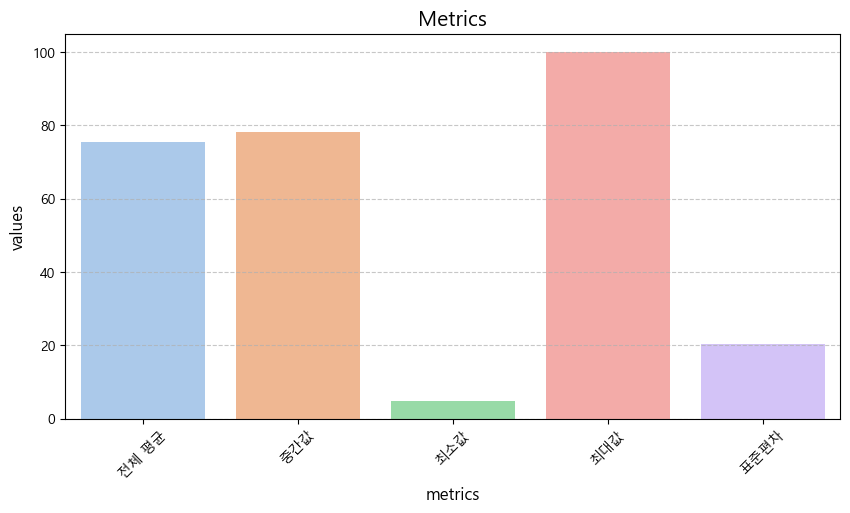

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

df = pd.DataFrame({'metrics': metrics, 'values': values})

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='metrics', y='values', palette='pastel')
plt.title('Metrics', fontsize=15)
plt.xlabel('metrics', fontsize=12)
plt.ylabel('values', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [156]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

mean_embedding_file1 = torch.mean(embeddings_file1, dim=1)
mean_embedding_file2 = torch.mean(embeddings_file2, dim=1)

# 유클리드 거리
euclidean_distance = euclidean_distances(mean_embedding_file1, mean_embedding_file2)

# 맨하탄 거리
manhattan_distance = manhattan_distances(mean_embedding_file1, mean_embedding_file2)

print("유클리드 거리:", euclidean_distance)
print("맨하탄 거리:", manhattan_distance)

유클리드 거리: [[0.        4.912401  0.        ... 0.        4.5657578 0.       ]
 [6.403377  4.3983426 6.403377  ... 6.403377  5.4473696 6.403377 ]
 [0.        4.912401  0.        ... 0.        4.5657578 0.       ]
 ...
 [4.8991303 2.9260159 4.8991303 ... 4.8991303 2.8848104 4.8991303]
 [6.985217  5.3490205 6.985217  ... 6.985217  6.194239  6.985217 ]
 [4.7802944 1.9955171 4.7802944 ... 4.7802944 2.3137589 4.7802944]]
맨하탄 거리: [[  0.         107.15214158   0.         ...   0.         100.80470804
    0.        ]
 [142.34176132  96.36534325 142.34176132 ... 142.34176132 119.41223959
  142.34176132]
 [  0.         107.15214158   0.         ...   0.         100.80470804
    0.        ]
 ...
 [107.09384508  64.92173143 107.09384508 ... 107.09384508  63.00043512
  107.09384508]
 [154.84693348 115.82586995 154.84693348 ... 154.84693348 133.40569676
  154.84693348]
 [105.27398051  44.95579413 105.27398051 ... 105.27398051  51.30848902
  105.27398051]]


In [162]:
# 유클리드 거리와 맨하탄 거리를 0에서 100% 범위로 변환
euclidean_distance_percent = ((euclidean_distance.max() - euclidean_distance) /
                              (euclidean_distance.max() - euclidean_distance.min())) * 100
manhattan_distance_percent = ((manhattan_distance.max() - manhattan_distance) /
                              (manhattan_distance.max() - manhattan_distance.min())) * 100

euclidean_mean = np.mean(euclidean_distance_percent)
euclidean_median = np.median(euclidean_distance_percent)
euclidean_min = np.min(euclidean_distance_percent)
euclidean_max = np.max(euclidean_distance_percent)
euclidean_std = np.std(euclidean_distance_percent)

manhattan_mean = np.mean(manhattan_distance_percent)
manhattan_median = np.median(manhattan_distance_percent)
manhattan_min = np.min(manhattan_distance_percent)
manhattan_max = np.max(manhattan_distance_percent)
manhattan_std = np.std(manhattan_distance_percent)

print(f"유클리드 거리의 전체 평균: {euclidean_mean:.2f}")
print(f"유클리드 거리의 중간값: {euclidean_median:.2f}")
print(f"유클리드 거리의 최솟값: {euclidean_min:.2f}")
print(f"유클리드 거리의 최댓값: {euclidean_max:.2f}")
print(f"유클리드 거리의 표준편차: {euclidean_std:.2f}")

print('-' * 50)

print(f"맨하탄 거리의 전체 평균: {manhattan_mean:.2f}")
print(f"맨하탄 거리의 중간값: {manhattan_median:.2f}")
print(f"맨하탄 거리의 최솟값: {manhattan_min:.2f}")
print(f"맨하탄 거리의 최댓값: {manhattan_max:.2f}")
print(f"맨하탄 거리의 표준편차: {manhattan_std:.2f}")

유클리드 거리의 전체 평균: 57.88
유클리드 거리의 중간값: 56.88
유클리드 거리의 최솟값: 0.00
유클리드 거리의 최댓값: 100.00
유클리드 거리의 표준편차: 25.26
--------------------------------------------------
맨하탄 거리의 전체 평균: 57.20
맨하탄 거리의 중간값: 56.32
맨하탄 거리의 최솟값: 0.00
맨하탄 거리의 최댓값: 100.00
맨하탄 거리의 표준편차: 25.56


In [167]:
threshold = 70

accuracy = (similarity_scores_percent > threshold).float().mean().item() * 100
print(f"음정 정확도: {accuracy:.2f}%")

음정 정확도: 63.30%
